In [1]:
import pandas as pd
import numpy as np
import datetime
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

In [2]:
#clusterID = np.load('LSTM_Model/Dataset_Competition/clusterID_genotype.npy')
weather = np.load('LSTM_Model/Dataset_Competition/Training/inputs_weather_train.npy')
traits = np.load('LSTM_Model/Dataset_Competition/Training/inputs_others_train.npy')
train_yield = np.load('LSTM_Model/Dataset_Competition/Training/yield_train.npy')

## Organizing Weather Data

In [3]:
perf_records, days, variables = weather.shape

In [4]:
out_arr = np.column_stack((np.repeat(np.arange(perf_records),days),weather.reshape(perf_records*days,-1)))
out_df = pd.DataFrame(out_arr)

In [5]:
out_df = pd.DataFrame(out_arr, columns=['Performance Record','ADNI', 'AP', 'ARH', 'MDNI', 'MaxSur', 'MinSur', 'AvgSur'])

In [6]:
out_df['Performance Record'] = pd.to_numeric(out_df['Performance Record']).astype(int)

In [7]:
## Counts all of the days in Performance Record
out_df['Day'] = out_df.groupby('Performance Record').cumcount() + 1

In [8]:
out_df['Julian_date'] = out_df.groupby('Performance Record').cumcount() + 91

In [9]:
def jdtodatestd (jdate):
    fmt = '%j'
    datestd = datetime.datetime.strptime(jdate, fmt).date()
    return(datestd)

In [10]:
subset = out_df[out_df['Performance Record'] == 0]

In [11]:
date_list = []
for i, row in subset.iterrows():
    julian = int(row['Julian_date'])
    date = datetime.datetime.strptime(f'{julian}', '%j').date()
    clean_date = date.strftime("%m-%d")
    date_list.append(clean_date)

In [12]:
date_cycle = cycle(date_list)
out_df['date'] = [next(date_cycle) for cycle in range(len(out_df))]

In [14]:
#out_df[["month", "day"]] = out_df["date"].str.split("-", expand = True)

In [15]:
# ax = sns.scatterplot(data = out_df[out_df['Performance Record'] == 0], x = 'date', y = 'AP')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
# plt.xticks(rotation=45);

## Other Trait Data

In [13]:
trait_df = pd.DataFrame(traits, columns=['Maturity Group', 'Genotype ID', 'State', 'Year', 'Location'])

In [14]:
trait_df['Year'] = pd.to_numeric(trait_df['Year'])
trait_df['Genotype ID'] = pd.to_numeric(trait_df['Genotype ID'])
trait_df['Year'] = trait_df['Year'].astype(int)
trait_df['Genotype ID'] = trait_df['Genotype ID'].astype(int)

In [15]:
#trait_df = trait_df.reset_index()

In [16]:
#trait_df.rename(columns = {'index':'Performance Record'}, inplace = True)

## Yield Data

In [17]:
yield_df = pd.DataFrame(train_yield)

In [18]:
yield_df.rename(columns = {0:'Yield'}, inplace = True)

In [19]:
## Merging the two

trait_df['Yield'] = yield_df['Yield']

In [23]:
## Comparing total yield for each state across all years

# sns.boxplot(data = trait_df, x = 'State', y = 'Yield', color = 'cornflowerblue')
# plt.xticks(rotation=90);

In [24]:
## Comparing average yield for each year

#sns.barplot(data = trait_df.groupby('Year').mean().reset_index(), x = 'Year', y = 'Yield', color = 'cornflowerblue')

In [25]:
# trait_df.to_csv('trait_df.csv')
# out_df.to_csv('weather_df.csv')

In [20]:
trait_df = trait_df.reset_index()

In [21]:
trait_df.rename(columns = {'index': 'Performance Record'}, inplace = True)

In [98]:
#test_df = pd.concat([trait_df]*214)

In [99]:
#test_df = test_df.sort_values(by = 'Performance Record')

In [51]:
#test_df.to_csv('expanded_df.csv')

In [100]:
#expanded_yield = test_df[['Performance Record', 'Yield']]

In [22]:
trait_df['State'] = trait_df['State'].str.replace('"', '')

In [108]:
values = trait_df.values

In [109]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import datetime
import pandas as pd
import scipy
from scipy import stats

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [120]:
values = trait_df.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7, 8, 9, 10, 11, 12]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.444444   0.041453   0.259259   0.500000   0.584337   
2   0.000011   0.777778   0.019356   0.000000   0.833328   0.090361   
3   0.000021   0.555556   0.492806   0.925926   1.000000   0.427711   
4   0.000032   0.444444   0.776636   0.518519   0.916672   0.560241   
5   0.000043   0.444444   0.770812   0.666667   0.416672   0.265060   

   var7(t-1)   var7(t)  
1   0.344643  0.480357  
2   0.480357  0.653571  
3   0.653571  0.629464  
4   0.629464  0.729464  
5   0.729464  0.375893  


In [121]:
# split into train and test sets
values = reframed.values
n_train_hours = 30000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30000, 1, 7) (30000,) (63027, 1, 7) (63027,)


Epoch 1/50
417/417 - 3s - loss: 0.2196 - val_loss: 0.1257
Epoch 2/50
417/417 - 1s - loss: 0.1237 - val_loss: 0.1257
Epoch 3/50
417/417 - 1s - loss: 0.1213 - val_loss: 0.1237
Epoch 4/50
417/417 - 1s - loss: 0.1195 - val_loss: 0.1224
Epoch 5/50
417/417 - 1s - loss: 0.1181 - val_loss: 0.1213
Epoch 6/50
417/417 - 2s - loss: 0.1171 - val_loss: 0.1206
Epoch 7/50
417/417 - 1s - loss: 0.1164 - val_loss: 0.1201
Epoch 8/50
417/417 - 2s - loss: 0.1160 - val_loss: 0.1197
Epoch 9/50
417/417 - 1s - loss: 0.1157 - val_loss: 0.1194
Epoch 10/50
417/417 - 1s - loss: 0.1155 - val_loss: 0.1189
Epoch 11/50
417/417 - 1s - loss: 0.1153 - val_loss: 0.1185
Epoch 12/50
417/417 - 1s - loss: 0.1152 - val_loss: 0.1181
Epoch 13/50
417/417 - 1s - loss: 0.1151 - val_loss: 0.1178
Epoch 14/50
417/417 - 1s - loss: 0.1151 - val_loss: 0.1174
Epoch 15/50
417/417 - 1s - loss: 0.1150 - val_loss: 0.1171
Epoch 16/50
417/417 - 1s - loss: 0.1150 - val_loss: 0.1168
Epoch 17/50
417/417 - 1s - loss: 0.1150 - val_loss: 0.1165
Epoch 

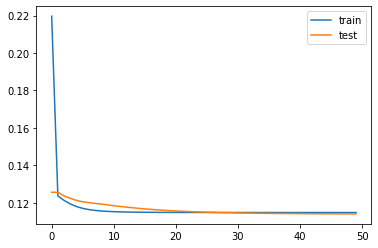

In [122]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [124]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: in user code:

    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_13 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 7)


## Summarizing weather data by year

In [21]:
weather_year = out_df.groupby('Performance Record').mean()

In [22]:
weather_year['Year'] = trait_df['Year']

In [23]:
weather_year['Yield'] = trait_df['Yield']

In [24]:
del weather_year['Day']

In [25]:
del weather_year['Julian_date']

In [35]:
weather_year = weather_year.set_index('Year')

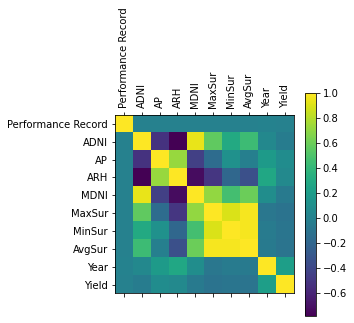

In [34]:
plt.matshow(weather_year.corr())
plt.xticks(np.arange(10), weather_year.columns, rotation=90)
plt.yticks(np.arange(10), weather_year.columns, rotation=0)
plt.colorbar()
plt.show()

In [26]:
trait_test = trait_df

In [29]:
trait_test['Yield'] = pd.to_numeric(trait_test['Yield'])

In [33]:
del trait_test['State']

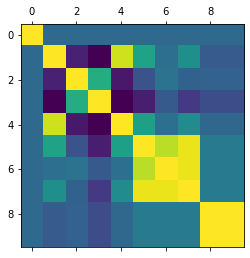

In [37]:
plt.matshow(out_df.corr())
# plt.xticks(np.arange(6), trait_test.columns, rotation=90)
# plt.yticks(np.arange(6), trait_test.columns, rotation=0)
# plt.colorbar()
plt.show()

In [31]:
trait_df

,Performance Record,Maturity Group,Genotype ID,State,Year,Location,Yield
0,0,3.0,243,KS,2009,98.0,39.0
1,1,6.0,114,AL,2013,16.0,54.2
2,2,4.0,2878,TN,2015,72.0,73.6
3,3,3.0,4535,MO,2014,94.0,70.9
4,4,3.0,4501,NE,2008,45.0,82.1
...,...,...,...,...,...,...,...
93023,93023,8.0,1774,AL,2014,144.0,22.2
93024,93024,4.0,1363,IL,2008,17.0,68.6
93025,93025,2.0,182,IN,2006,150.0,65.6
93026,93026,5.0,699,LA,2008,1.0,43.5
